In [2]:
import pandas as pd

# Cargar el archivo
file_path = './data/orders_orders.xlsx'
df = pd.read_excel(file_path)

# Ver rango de fechas
print("Rango de fechas:", df['Order Date'].min(), "a", df['Order Date'].max())


Rango de fechas: 2011-01-01 00:00:00 a 2014-12-31 00:00:00


In [5]:
# Filtrar Train y Test
train = df[(df['Order Date'] >= '2011-01-01') & (df['Order Date'] <= '2013-12-31')]
test = df[(df['Order Date'] >= '2014-01-01') & (df['Order Date'] <= '2014-12-31')]

# Resamplear datos a nivel semanal (sumatorio de ventas por semana)
train_weekly = train.resample('W-MON', on='Order Date')['Sales'].sum().reset_index()
test_weekly = test.resample('W-MON', on='Order Date')['Sales'].sum().reset_index()

# Diferenciar las ventas semanales para hacerlas estacionarias
train_weekly['Sales_diff'] = train_weekly['Sales'] - train_weekly['Sales'].shift(1)
test_weekly['Sales_diff'] = test_weekly['Sales'] - test_weekly['Sales'].shift(1)



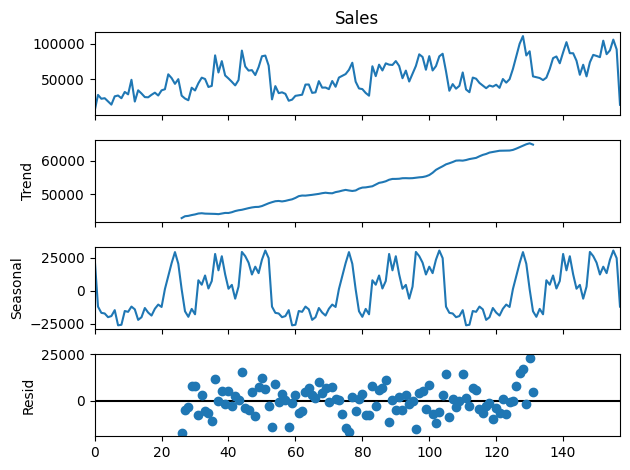

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición de Train
decomposition = seasonal_decompose(train_weekly['Sales'].dropna(), model='additive', period=52)

# Visualización de la tendencia, estacionalidad y residuos
decomposition.plot()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Test ADF para Train
adf_train = adfuller(train_weekly['Sales_diff'].dropna())
print("Train ADF Test Statistic:", adf_train[0])
print("p-value:", adf_train[1])
print("Critical Values:", adf_train[4])

# Test ADF para Test
adf_test = adfuller(test_weekly['Sales_diff'].dropna())
print("Test ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])


Train ADF Test Statistic: -6.503963951391895
p-value: 1.1433854691400356e-08
Critical Values: {'1%': -3.4759527332353084, '5%': -2.881548071241103, '10%': -2.577438765246763}
Test ADF Test Statistic: -5.05362870800744
p-value: 1.7362909675704197e-05
Critical Values: {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Modelo ARIMA en datos diferenciados de Train semanal
arima_model = ARIMA(train_weekly['Sales_diff'].dropna(), order=(1, 1, 1)).fit()

# Predicciones en Test semanal
arima_forecast_diff = arima_model.forecast(steps=len(test_weekly['Sales_diff'].dropna()))

# Reintegración de las predicciones a la escala original
arima_forecast = arima_forecast_diff.cumsum() + train_weekly['Sales'].iloc[-1]

# Ajustar la predicción para que coincida con el número de semanas en Test
arima_forecast = arima_forecast[:len(test_weekly)]



c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillem\App

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelo SARIMA en datos diferenciados de Train semanal
sarima_model = SARIMAX(train_weekly['Sales_diff'].dropna(), 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 52)).fit()

# Predicciones en Test semanal
sarima_forecast_diff = sarima_model.forecast(steps=len(test_weekly['Sales_diff'].dropna()))
sarima_forecast = sarima_forecast_diff.cumsum() + train_weekly['Sales'].iloc[-1]

# Ajustar la predicción para que coincida con el número de semanas en Test
sarima_forecast = sarima_forecast[:len(test_weekly)]



c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with a

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluación para ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_weekly['Sales'], arima_forecast))
arima_mae = mean_absolute_error(test_weekly['Sales'], arima_forecast)

# Evaluación para SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test_weekly['Sales'], sarima_forecast))
sarima_mae = mean_absolute_error(test_weekly['Sales'], sarima_forecast)

print("ARIMA - RMSE:", arima_rmse, "MAE:", arima_mae)
print("SARIMA - RMSE:", sarima_rmse, "MAE:", sarima_mae)



ValueError: Found input variables with inconsistent numbers of samples: [53, 52]

c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: x and y must have same first dimension, but have shapes (53,) and (52,)

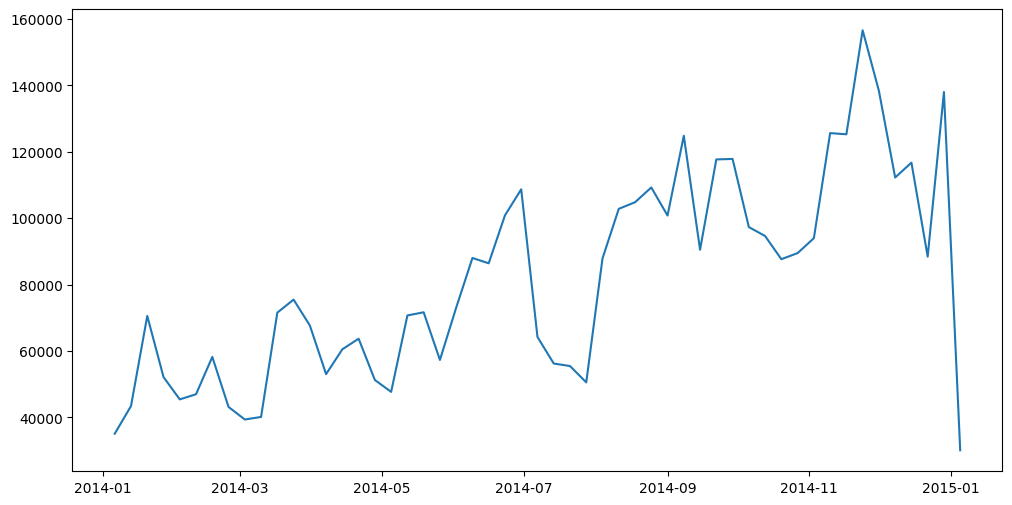

In [11]:
# Predicciones para 2015 (52 semanas)
sarima_2015_forecast_diff = sarima_model.get_forecast(steps=52).predicted_mean
sarima_2015_forecast = sarima_2015_forecast_diff.cumsum() + train_weekly['Sales'].iloc[-1]

# Visualización de las predicciones
plt.figure(figsize=(12, 6))
plt.plot(test_weekly['Order Date'], test_weekly['Sales'], label='Datos Reales (2014)')
plt.plot(test_weekly['Order Date'], sarima_forecast, label='Predicciones (2014)')
plt.plot(pd.date_range('2015-01-05', periods=52, freq='W-MON'), sarima_2015_forecast, label='Predicciones (2015)', color='orange')
plt.legend()
plt.show()



In [18]:
from pmdarima import auto_arima

# GridSearch para SARIMA en datos semanales
auto_model = auto_arima(train_weekly['Sales_diff'].dropna(), 
                        seasonal=True, m=52, 
                        trace=True, 
                        error_action='ignore', 
                        suppress_warnings=True, 
                        stepwise=True)

print("Mejores parámetros SARIMA:")
print("Order:", auto_model.order)
print("Seasonal Order:", auto_model.seasonal_order)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=92.71 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3473.940, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3466.313, Time=25.89 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3467.002, Time=26.33 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3471.942, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3470.000, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=369.72 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3465.635, Time=33.31 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3468.414, Time=31.30 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=3463.192, Time=894.78 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=3464.841, Time=2077.79 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=959.33 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=1989.45 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=3463.840, Time=6932.59 sec
 ARIMA(1,0,1)(2,0,1

KeyboardInterrupt: 

In [ ]:
# Retrain con los mejores parámetros encontrados
best_sarima_model = SARIMAX(train_weekly['Sales_diff'].dropna(),
                            order=auto_model.order,
                            seasonal_order=auto_model.seasonal_order).fit()

# Predicciones en Test semanal
best_sarima_forecast_diff = best_sarima_model.forecast(steps=len(test_weekly['Sales_diff'].dropna()))
best_sarima_forecast = best_sarima_forecast_diff.cumsum() + train_weekly['Sales'].iloc[-1]

# Ajustar la predicción para que coincida con el número de semanas en Test
best_sarima_forecast = best_sarima_forecast[:len(test_weekly)]



In [ ]:
# Evaluación del modelo optimizado
best_sarima_rmse = np.sqrt(mean_squared_error(test_weekly['Sales'], best_sarima_forecast))
best_sarima_mae = mean_absolute_error(test_weekly['Sales'], best_sarima_forecast)

print("SARIMA Optimizado - RMSE:", best_sarima_rmse, "MAE:", best_sarima_mae)
